# Setup

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install

In [2]:
!pip install scattertext
!pip install pyLDAvis

## Import

In [3]:
# Importing the required libraries
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
import gensim
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from gensim.models import TfidfModel
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import spacy
import string
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scattertext as st
from collections import Counter
import re, io
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from pprint import pprint
from scipy.stats import rankdata, hmean, norm
import spacy
import scattertext as st
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


## Viewing

In [76]:
#save default font settings
IPython_default = plt.rcParams.copy()

# set fonts / set text size
#@title matplotlib font settings
small_text = 15 #@param {type:"integer"}
medium_text = 26 #@param {type:"integer"}
large_text = 28 #@param {type:"integer"}
line_marker_size = 5 #@param {type:"slider", min:0, max:10, step:0.5}
legend_shadow = True #@param {type:"boolean"}
fig_width =  8 #@param {type:"number"}
fig_height =  6 #@param {type:"number"}
sns_style = "ticks" #@param ["darkgrid", "whitegrid", "dark", "white", "ticks"]
axis_grid = True #@param {type:"boolean"}
sns_palette = "deep" #@param ["pastel", "muted", "bright", "deep", "colorblind", "dark"]

import matplotlib.pyplot as plt
import seaborn as sns

# restore defaults
plt.rcdefaults()

#run configuration parameters
plt.rcParams['axes.labelsize']   = small_text
plt.rcParams['axes.titlesize']   = small_text
plt.rcParams['xtick.labelsize']  = small_text
plt.rcParams['ytick.labelsize']  = small_text
plt.rcParams['legend.fontsize']  = small_text
plt.rcParams['legend.shadow']    = legend_shadow
plt.rcParams['lines.markersize'] = line_marker_size
plt.rcParams['figure.figsize']   = (fig_width, fig_height)
plt.rcParams['font.size']        = small_text

# seaborn settings
sns.set_style(sns_style, {"axes.grid": axis_grid})
sns.set_palette(sns_palette)

### Wordwrap and table font settings


In [5]:
# enable wordwrap
#https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
    td,th,p {
        font-size: 18px
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### Dataframe options

In [6]:
pd.options.display.float_format = "{:,.2f}".format

# Descriptive Statistics

## Read Dataset

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/data/twcs.csv')

## DataFrame Shape

In [8]:
print(f'DataFrame shape: {df.shape}')
rows, cols = df.shape
print(f'Rows: {rows}')
print(f'Cols: {cols}')
print(f'{df.info()}')

DataFrame shape: (2811774, 7)
Rows: 2811774
Cols: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB
None


## First 5 and Last 5 Rows

In [9]:
pd.concat([df.head(), df.tail()])

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.00
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.00
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.00
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.00
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.00
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,"2,987,948.00"
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,"2,812,239.00"
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,"2,987,950.00"
2811773,2987950,823870,True,Tue Nov 21 22:01:04 +0000 2017,@AldiUK warm sloe gin mince pies with ice cre...,"2987951,2987949",NaN


# Preprocessing

## Store Tweet Text

In [10]:
# Store text in a variable
tweet_text = df[['text']]

## Drop columns and remove nulls in the text column

In [11]:
# Let us clean the tweet text for better visualization
df.drop('tweet_id', axis = 1, inplace = True)
df.drop('created_at', axis = 1, inplace = True)
df = df[~df['text'].isnull()]

## Clean text

In [12]:
def preprocess(CleanText):
    CleanText = CleanText.str.replace("(<br/>)", "")
    CleanText = CleanText.str.replace('(<a).*(>).*(</a>)', '')
    CleanText = CleanText.str.replace('(&amp)', '')
    CleanText = CleanText.str.replace('(&gt)', '')
    CleanText = CleanText.str.replace('(&lt)', '')
    CleanText = CleanText.str.replace('(\xa0)', ' ')

    CleanText = CleanText.str.replace('http\\S+|www.\\S+', '')
    CleanText = CleanText.str.replace('@[A-Za-z0-9]+', '')
    CleanText = CleanText.str.replace('^ ', '')
    return CleanText

df['text'] = preprocess(df['text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarnin

# Plot Distributions

## Create 'words_per_tweet'

In [13]:
df['words_per_tweet'] = [len(x.split()) for x in df['text'].tolist()]
df[['text', 'words_per_tweet']].head(5)

,text,words_per_tweet
0,I understand. I would like to assist you. We w...,22
1,and how do you propose we do that,8
2,I have sent several private messages and no on...,13
3,Please send us a Private Message so that we ca...,22
4,I did.,2


In [14]:
df[['words_per_tweet']].describe().T

,count,mean,std,min,25%,50%,75%,max
words_per_tweet,"2,811,774.00",18.15,9.58,0.00,12.00,18.00,23.00,137.00


## Determine number of bins

In [15]:
q25, q75 = np.percentile(df['words_per_tweet'], [25, 75])
print(f'25th Quartile: {q25}, 75th Quartile: {q75}')
print(f"Len words per tweet: {len(df['words_per_tweet'])}")
bin_width = 2 * (q75 - q25) / np.cbrt(len(df['words_per_tweet']))
print(f'bin_width: {bin_width}')
bins = round((df['words_per_tweet'].max() - df['words_per_tweet'].min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

25th Quartile: 12.0, 75th Quartile: 23.0
Len words per tweet: 2811774
bin_width: 0.15587000304877274
Freedman–Diaconis number of bins: 879


## Create 'char_count'

In [16]:
# Finding the number of characters in each tweet incuding the spaces
df['char_count'] = df['text'].str.len() 
df[['text','char_count']].head()

,text,char_count
0,I understand. I would like to assist you. We w...,113
1,and how do you propose we do that,33
2,I have sent several private messages and no on...,70
3,Please send us a Private Message so that we ca...,116
4,I did.,6


## Create 'stopwords'

In [17]:
# Let us take a look at the number of stopwords in the tweets
import nltk 
nltk.download('stopwords')
stopword = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stopword]))
df[['text','stopwords']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,stopwords
0,I understand. I would like to assist you. We w...,7
1,and how do you propose we do that,7
2,I have sent several private messages and no on...,5
3,Please send us a Private Message so that we ca...,10
4,I did.,0


In [18]:
df[['text','stopwords']].describe().T


,count,mean,std,min,25%,50%,75%,max
stopwords,"2,811,774.00",6.61,4.52,0.00,3.00,6.00,9.00,38.00


## Draw Graphs

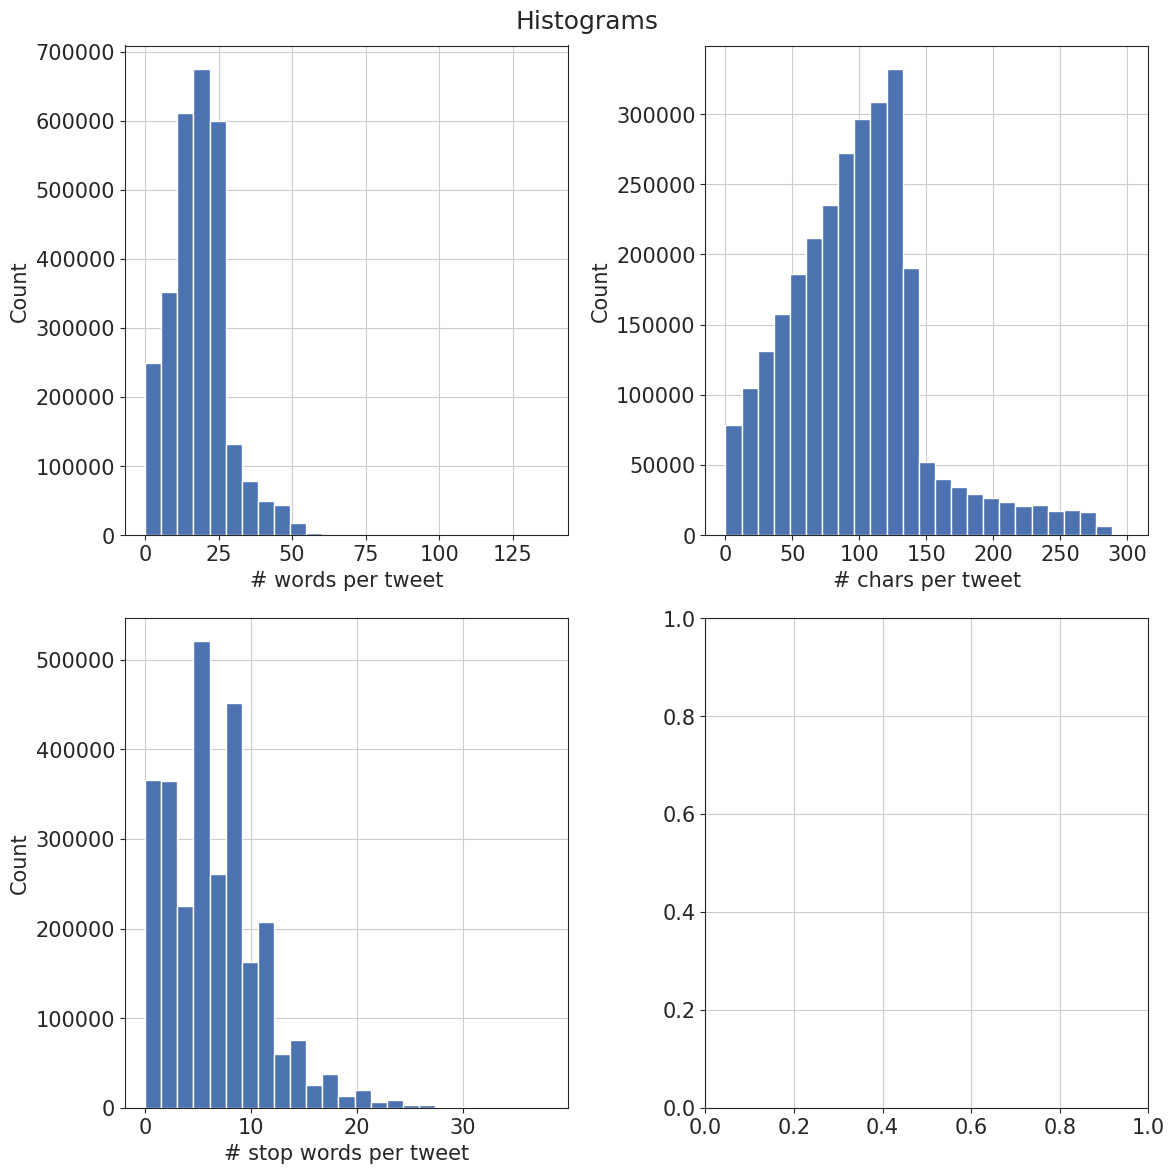

In [19]:
fig, axes = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Histograms')
xs = [df['words_per_tweet'], df['char_count'], df['stopwords']]
labels = ['# words per tweet', '# chars per tweet', '# stop words per tweet']
bins = [25,25,25]

for ax, x, lbl, bin in zip(axes.flat, xs, labels, bins):
    ax.hist(x, bins=bin)
    ax.ticklabel_format(style='plain')
    ax.set_xlabel(lbl)
    ax.set_ylabel('Count')
fig.tight_layout()
fig.subplots_adjust(top=.95)
plt.show()


# Removing stopwords from the tweets

In [21]:
# Removing stopwords and punctuations from the tweets
df['text'] = df['text'].str.replace('[^\w\s]','')
df['text'].head()
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopword))
df['text'].head()

<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-21-cb0d62e77082>:2: DeprecationWarning: invalid escape sequence \w
  df['text'] = df['text'].str.replace('[^\w\s]','')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0    I understand I would like assist We would need...
1                                              propose
2    I sent several private messages one responding...
3    Please send us Private Message assist Just cli...
4                                                    I
Name: text, dtype: object

# Pip List

In [22]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

# Upgrade WordCloud

In [ ]:
#!pip install wordcloud --upgrade

# Draw Wordcloud

In [ ]:
from wordcloud import WordCloud
# Let us take a look at the most frequently used word in the tweets
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'Blues', 
                       margin = 0,
                       max_words = 200,
                       min_word_length = 4,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(df['text']))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

# Tweets per organization

In [52]:
print("Word Count of tweets for each Twitter Account")
tweets_per_person = df.groupby('author_id').apply(lambda x: x.text.apply(lambda x: len(x.split())).sum())
tweets_per_org = tweets_per_person[tweets_per_person.index.str.isdecimal() == False].sort_values(ascending=False)

Word Count of tweets for each Twitter Account


## Reset Index

In [53]:
#print(type(tweets_per_org))
tweets_per_org = tweets_per_org.reset_index()

## Print Table

In [57]:
print(list(tweets_per_org.columns))
print(type(tweets_per_org))
tweets_per_org = tweets_per_org.rename(columns={'author_id': 'organization', 0: '# of tweets'})
#tweets_per_org['organization'] = tweets_per_org.index
display(tweets_per_org)
#tweets_per_org.rename(

['author_id', 0]
<class 'pandas.core.frame.DataFrame'>


,organization,# of tweets
0,AmazonHelp,2022366
1,AppleSupport,1247847
2,SpotifyCares,566410
3,Uber_Support,544180
4,Tesco,543951
...,...,...
103,OfficeSupport,2360
104,CarlsJr,1972
105,AskDSC,1710
106,HotelTonightCX,1613


## Show Palette

In [78]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [81]:
print(sns_palette)

deep


## Draw Top 20 Organizations Barchart

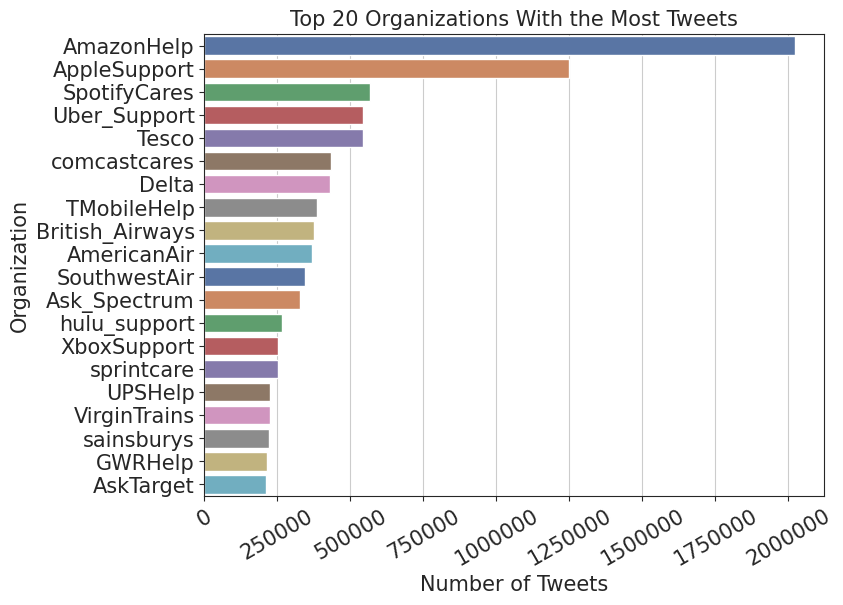

In [125]:
fig, ax = plt.subplots(1,1)
ax.ticklabel_format(style='plain')
ax = sns.barplot(x = tweets_per_org['# of tweets'][:20], 
            y = tweets_per_org['organization'][:20], palette=sns_palette)
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_ylabel('Organization')
ax.set_xlabel('Number of Tweets')
ax.set_title('Top 20 Organizations With the Most Tweets')
plt.show()
#plt.tight_layout()



# Visualize unigrams

In [127]:
# Defining a function to visualise n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

# Most Frequent Unigrams

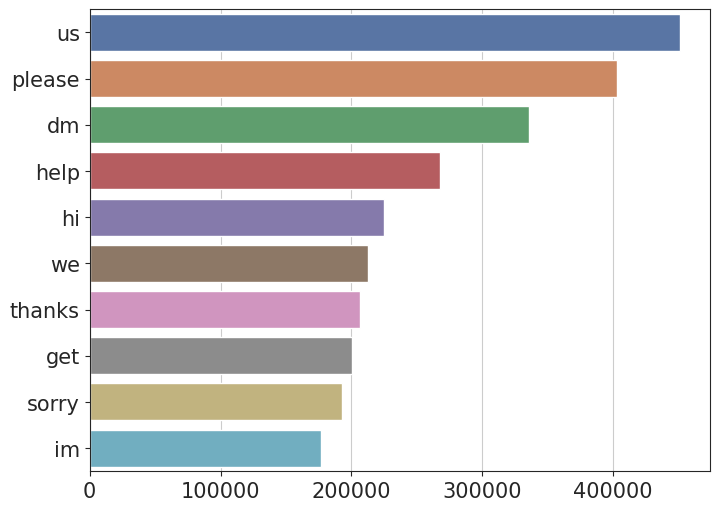

In [128]:
# Visualizing the most frequent unigrams in the tweets
top_unigrams = get_top_ngram(df['text'],1)[:10]
x,y = map(list,zip(*top_unigrams))
sns.barplot(x = y,y = x)

# Most Frequent Bigrams

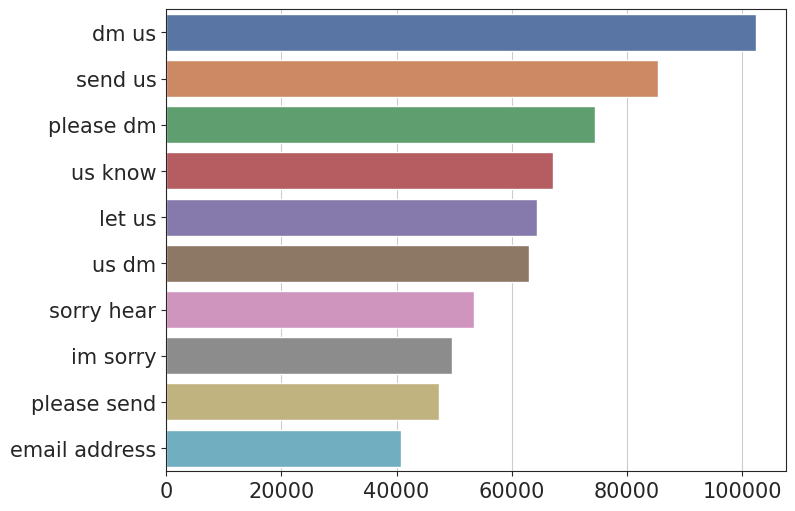

In [129]:
# Visualising the most frequent bigrams in the tweets
top_bigrams = get_top_ngram(df['text'],2)[:10]
x,y = map(list,zip(*top_bigrams))
sns.barplot(x = y,y = x)

# Most Frequent Trigrams

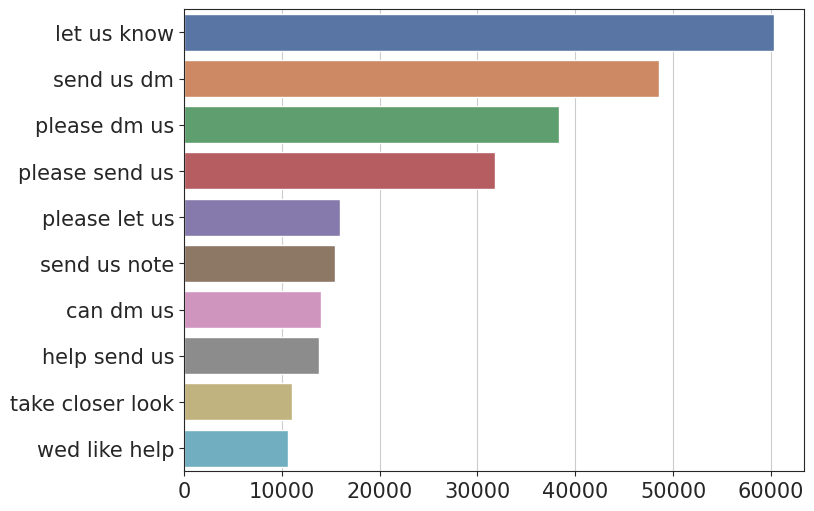

In [130]:
# Visualising the most frequent trigrams in the tweets
top_trigrams = get_top_ngram(df['text'],3)[:10]
x,y = map(list,zip(*top_trigrams))
sns.barplot(x = y,y = x)

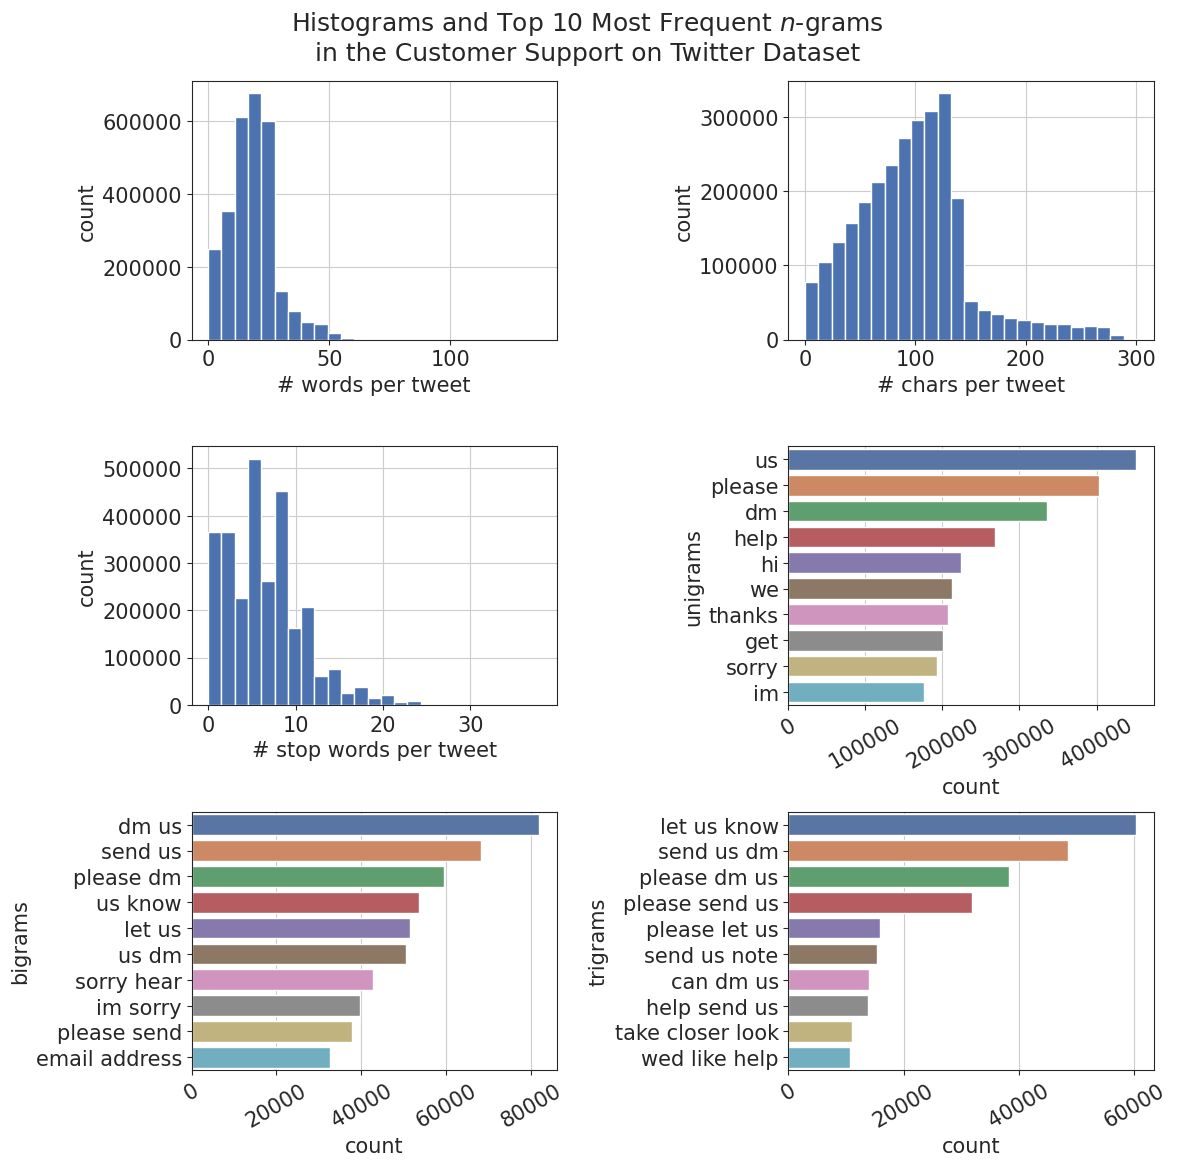

In [163]:
# Defining a function to visualise n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

fig, axes = plt.subplots(3,2,figsize=(12,12))
fig.suptitle('Histograms and Top 10 Most Frequent $n$-grams\nin the Customer Support on Twitter Dataset')
xs = [df['words_per_tweet'], df['char_count'], df['stopwords']]
ylbls = 3 * ['count']
ylbls.extend(['unigrams', 'bigrams', 'trigrams'])
xlbls = ['# words per tweet', '# chars per tweet', '# stop words per tweet']
xlbls += 3 * ['count']
bins = [25,25,25]
ngrams = [0,0,0,1,2,3]
xs += 3 * [0]
bins += 3 * [0]

for i, (ax, x, xlbl, ylbl, bin, n) in enumerate(zip(axes.flat, xs,
                                                    xlbls, ylbls, bins, ngrams)):
    if (i <= 2):
        ax.hist(x, bins=bin)
        ax.ticklabel_format(style='plain')
        ax.set_xlabel(xlbl)
        ax.set_ylabel(ylbl)

    elif (i > 2):
        top_ngrams = get_top_ngram(df['text'],n)[:10]
        x,y = map(list,zip(*top_ngrams))
        ax = sns.barplot(x=y,y=x,ax=ax)
        plt.draw()
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
        ax.set_xlabel(xlbl)
        ax.set_ylabel(ylbl)

fig.tight_layout()
fig.subplots_adjust(top=.92)
plt.show()

In [ ]:
reindexed_data = df['text']
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

## Function to return an integer list of predicted topic categories for the topic matrix
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis = 1).tolist()
    return keys

## Function to return a tuple of topic categories 
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

## Function to return a list of n topics
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
# Printing the most common topics 
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

In [ ]:
# Pre processing the tweets by performing stemming and lemmatization using nltk
def preprocess_tweets(df):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for tweets in df['text']:
        words = [w for w in word_tokenize(tweets) if (w not in stopword)]
        
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus = preprocess_tweets(df)

In [ ]:
# Creating the LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 5, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()